# Algorithm Selection

Exploratory Data Analysis showed that some features present high colinearity. Highly colinear features can affect the stability of machine learning models. 

In this notebook, we build, train and evaluate:
- Lasso Regression because it automatically eliminates unnecessary features,
- Random Forest because it is robust to features colinearity.


Other options we could explore to work around features colinearity are:
- perform PCA to get a project non-colinear subset of initial features
- perform feature selection by incrementally eliminating features that don't improve evaluation scores.


#### Summary of results from this notebook

- Both Random Forest and Lasso Regression outperform the baseline model.
- Random Forest cross-validated yields to better RMSE on the test set compared to Lasso cross-validated.
- Random Forest RMSE on the test set is very low compared to the train set error. The model is probably overfitting the training set. We will use regularization.
- Given these results, we will pick the Random Forest algorithm. We will use cross-validation for hyper-parameter tuning. 

The rest of the notebook explains how we derived these conclusions.

#### Read in train processed data

In [1]:
import sys
sys.path.insert(0,'/Users/Armin/Desktop/MyFirstMLOps/auto-mpg/')

In [2]:
import pandas as pd
from src.utils import data_path

df_train = pd.read_pickle(data_path("processed", "train_processed.pkl"))

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  318 non-null    float64
 1   horsepower    318 non-null    float64
 2   weight        318 non-null    float64
 3   acceleration  318 non-null    float64
 4   cylinders     318 non-null    float64
 5   year          318 non-null    float64
 6   x0_ASIA       318 non-null    float64
 7   x0_USA        318 non-null    float64
 8   mpg           318 non-null    float64
dtypes: float64(9)
memory usage: 22.5 KB


In [5]:
df_train.head()

,displacement,horsepower,weight,acceleration,cylinders,year,x0_ASIA,x0_USA,mpg
0,1.090196,1.266232,0.552826,-1.319334,1.527188,-1.696667,0.0,1.0,16.0
1,-0.922996,-0.407925,-0.999667,-0.413182,-0.850515,-1.696667,1.0,0.0,27.0
2,-0.981350,-0.947975,-1.124772,0.927922,-0.850515,1.638975,1.0,0.0,37.0
3,-0.981350,-1.163996,-1.392854,0.275493,-0.850515,0.527094,1.0,0.0,36.1
4,-0.747936,-0.218907,-0.327675,-0.231952,-0.850515,-0.306816,0.0,0.0,23.0


<IPython.core.display.Javascript object>

In [4]:
X_train = df_train.drop("mpg", axis=1)
y_train = df_train["mpg"]

## Lasso Regression 

In [5]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV
from src.train import rmse_cross_validate

mse_scorer = make_scorer(mean_squared_error)

alphas = [0.01 * i for i in range(1, 11)]
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42)

lasso_cv_results = cross_validate(
    lasso_cv,
    X_train,
    y_train,
    cv=10,
    return_estimator=True,
    return_train_score=True,
    scoring={"mse": mse_scorer},
)
rmse_cross_validate(lasso_cv_results)

,rmse,rmse_std
train,3.388,0.039
test,3.463,0.397


#### Imports for visualization 

In [6]:
import matplotlib.pyplot as plt

plt.style.use("classic")
# plt.rcParams["font.size"] = 24
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")
# sns.set(font_scale=2)

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

###  Lasso paramameters stabilty

#### Check `alpha` 

Lasso parameter `alpha` is the regularization parameter. It penalises the number of features in the model to keep only the most important ones. 

The higher the `alpha`, the most features will have their coefficient zeroed. When `alpha` is set at zero, Lasso Regression is equivalent to linear regression without regularization. 

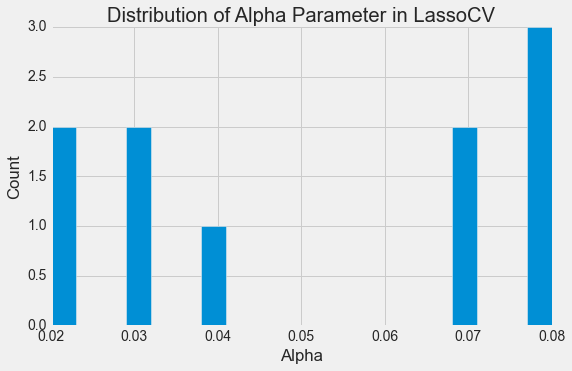

In [7]:
figsize(8, 5)
alphas = [model.alpha_ for model in lasso_cv_results["estimator"]]
plt.style.use("fivethirtyeight")
plt.hist(alphas, bins=20)
sns.despine()
plt.xlabel("Alpha")
plt.ylabel("Count")
plt.title("Distribution of Alpha Parameter in LassoCV")
plt.show()

In [8]:
import numpy as np

print("alphas mean:", np.mean(alphas).round(3))
print("alphas std:", np.std(alphas).round(3))

alphas mean: 0.052
alphas std: 0.025


The values of `alpha` aren't consistent across cross-valiadation.

#### Check coeffients 

In [9]:
params = [model.coef_ for model in lasso_cv_results["estimator"]]
df_lasso_cv_params = pd.DataFrame(np.stack(params), columns=X_train.columns)
df_lasso_cv_params.describe().loc[["mean", "std"], :]

,displacement,horsepower,weight,acceleration,cylinders,year,x0_ASIA,x0_USA
mean,0.598541,-0.270672,-5.255523,0.076675,-0.028236,2.856473,-0.005707,-2.122249
std,0.685352,0.189645,0.431047,0.086761,0.089291,0.079348,0.018047,0.393080


Lasso coefficients vary with the training example. The Lasso model seems unstable across the different training samples.
Tibshirani identified the conditions for Lasso "uniqueness" in this 2013 paper [[1]](https://projecteuclid.org/download/pdfview_1/euclid.ejs/1369148600).
One of these conditions is continuous features. Cylinders, Year and Region are categorical.
Useful papers to read about Lasso model instability:
- [Sparse Algorithms are not Stable](http://users.ece.utexas.edu/~cmcaram/pubs/XuCaramanisMannor.NFL.pdf)
- [The lasso problem and uniqueness](https://projecteuclid.org/download/pdfview_1/euclid.ejs/1369148600)
- [Stack overflow question and answers](https://stats.stackexchange.com/questions/365938/what-causes-lasso-to-be-unstable-for-feature-selection)


From the coefficients, we can also see that LassoCV uses `weight` and `year` as top predictors. Features that are highly correlated to `weight` like `horsepower` or `displacement` have coefficients closer to zero.

## Random Forest 

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]}]
rf = RandomForestRegressor(random_state=42)

rfcv = GridSearchCV(rf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

rfcv_results = cross_validate(
    rfcv,
    X_train,
    y_train,
    cv=10,
    return_estimator=True,
    return_train_score=True,
    n_jobs=-1,
    scoring={"mse": mse_scorer},
)
rmse_cross_validate(rfcv_results)

,rmse,rmse_std
train,1.129,0.033
test,2.827,0.485


#### Compare to LassoCV 

In [11]:
rmse_cross_validate(lasso_cv_results)

,rmse,rmse_std
train,3.388,0.039
test,3.463,0.397


###  RF params statbilty

In [12]:
[model.best_params_ for model in rfcv_results["estimator"]]

[{'max_features': 2, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 4, 'n_estimators': 30}]

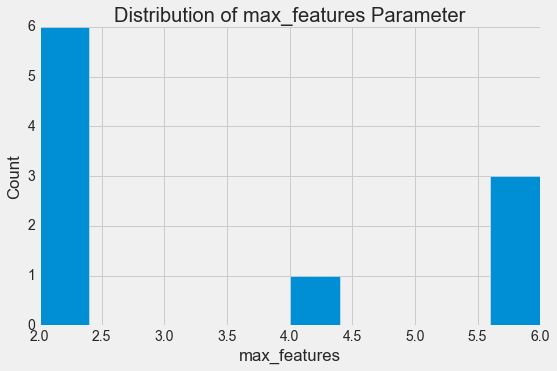

In [13]:
max_features = [
    model.best_params_["max_features"] for model in rfcv_results["estimator"]
]
plt.hist(max_features)
sns.despine()
plt.xlabel("max_features")
plt.ylabel("Count")
plt.title("Distribution of max_features Parameter")
plt.show()

There is some variability for the choice of parameters of the cross-validation for Randon Forest but much less than for LassoCV.

## Conclusions

Random Forest cross-validated yields to better RMSE on the test set compared to Lasso cross-validated.

Random Forest is probably overfitting the training set. Regularization might help with overfitting.

There is a variablity in `max_features` parameter. The relatively small size of the training set might cause this instablity.

Given these results, we will pick Random Forest algorithm. We won't use nested cross-validation but simple cross-validation to finetuning. This way the model will access more instances to train on.
